In [1]:
# Importing all the necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics
from torchmetrics import Dice, JaccardIndex
from tqdm import tqdm
from skimage import io
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import utils
import torchvision.transforms.functional as TF
import random
import torchvision.models as models
from torch.nn.functional import interpolate
from datetime import datetime

# Check if GPU is available for training
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [2]:
# Hyperparameters

LEARNING_RATE = 0.00001
WEIGHT_DECAY = 1e-5 # For regularization in Adam Optimizer
UNFREEZE_WEIGHTS = False # If resnet weights need to be frozen or not
EPOCHS = 10
EPOCH_FREEZE = 0 # After how many epochs to unfreeze encoder
PROB_THRESHOLD = 0.5 # Threshold at which glacier is classified
MAKE_CSV = True # If training data csv is needed or not
TEST_SIZE = 0.1 # Fraction of total data to be used as test set
TRANSFORMS = True # Augment training data with transformations (rotation etc)
LOSS = 'ce' # Type of loss function Cross Entropy 'ce', Mean Sq Error 'mse'
SMOOTH_FACTOR = 0.0001 # Added while calculatin NDSI & NDWI to avoid invalid values
BATCH_SIZE = 16 # Number of images per training batch
SHUFFLE_DATASET = False # Shuffle dataset while training and testing
TRAINING_DATA = 'training/src/training_data' # Folder containing training data
# Defining Dice score and Jaccard Index functions
DICE = Dice(average='micro', threshold = PROB_THRESHOLD).to(device)
JAC = JaccardIndex(task="multiclass", num_classes=2, threshold = PROB_THRESHOLD).to(device)

In [3]:
# Making dataset - images and masks folder should be in a folder named training_data

if MAKE_CSV:
    mypath = TRAINING_DATA+'/masks'

    # List of all mask files
    mask_files = [TRAINING_DATA+'/masks/'+f for f in listdir(mypath) if isfile(join(mypath, f))]

    # List to store all valid images
    valid_imgs = []

    for img_path in mask_files:
        img = io.imread(img_path)

        # If variance in a mask is above 0.001, we keep it
        # Basically it eliminates images that are almost blank
        if img.var() > 0.001:
            valid_imgs.append(img_path[-18:])


    # Making file path for images
    img_files = ['images/'+ i for i in valid_imgs]
    mask_files = ['masks/'+ i for i in valid_imgs]

    # Creating dataframe of image and mask paths
    df = pd.DataFrame(list(zip(img_files, mask_files)), columns=[['img', 'mask']])
    df = df.sample(frac=1).reset_index(drop=True)

    # Separating training and test set
    train = df[:int((1-TEST_SIZE)*len(df))]
    train = train.reset_index()[['img', 'mask']]
    test = df[int((1-TEST_SIZE)*len(df)):]

    # Saving images and mask paths to csv
    train.to_csv('train_clean.csv', index = False)
    test.to_csv('test_clean.csv', index = False)

In [4]:
# Custom Dataloader

class GlacierDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None):
        # Loading image and mask paths from csv file
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        # Loading transforms to be applied to images & masks
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Load image from path
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = torch.tensor(io.imread(img_path).transpose(2,0,1)).float() # N, H, W format

        # Creating variables for bands: Green, Short-wave infrared & Near Infrared band
        green = image[1]
        swir = image[4]
        nir = image[3]

        # Calculating Normalized Difference Snow Index
        ndsi = (green - swir + SMOOTH_FACTOR)/(green + swir+ SMOOTH_FACTOR)
        ndsi = ndsi.unsqueeze(dim=0)
        # Adding NDSI to the bands
        image = torch.cat((ndsi, image), dim=0)

        # Calculating Normalized Difference Water Index
        ndwi = (green - nir + SMOOTH_FACTOR)/(green + nir+ SMOOTH_FACTOR)
        ndwi = ndwi.unsqueeze(dim=0)
        # Adding NDWI to the bands
        image = torch.cat((ndwi, image), dim=0)

        # Loading Masks
        label_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        label = torch.tensor(io.imread(label_path).transpose(2,0,1))

        # Applying transforms to images & masks
        if self.transform:
            # Flipping image & masks vertically randomly with given probability
            if random.random() > 0.5:
                image = TF.vflip(image)
                label  = TF.vflip(label)
            # Flipping image & masks horizontally randomly with given probability
            if random.random() > 0.5:
                image = TF.hflip(image)
                label  = TF.hflip(label)
            # Flipping image & masks vertically randomly with given probability
            if random.random() > 0.5:
                image = TF.gaussian_blur(image,3)
                label  = TF.gaussian_blur(label,3)
            # Other transforms Brightness & Shear can be added

        return image, label



In [5]:
# Loading dataset into PyTorch dataloaders
train_dataset = GlacierDataset('train_clean.csv', TRAINING_DATA, transform=TRANSFORMS)
test_dataset = GlacierDataset('test_clean.csv', TRAINING_DATA, transform=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE_DATASET)

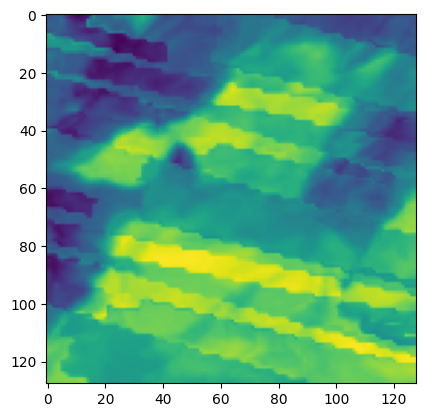

In [6]:
# Display loaded bands
imgs, lbls = next(iter(train_dataloader))
plt.imshow(imgs[0][1])

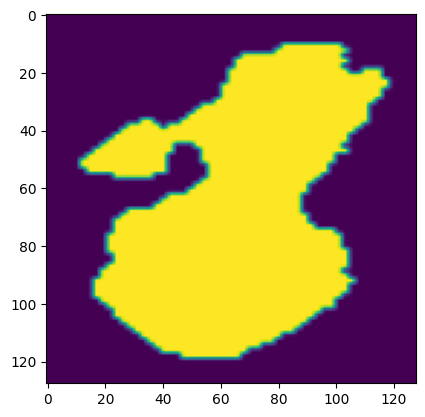

In [7]:
# Display loaded masks
plt.imshow(lbls[0][0])

In [8]:
# Convolutional Model Architecture

class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class UNet(nn.Module):
    def __init__(self, n_class, freeze_encoder=True):

        # Number of Classes
        self.n_class = n_class
        # Should pre-trained encoder weights be trained or not
        self.freeze_encoder = freeze_encoder
        super(UNet, self).__init__()

        # Loading resnet-50 pre-trained model
        resnet = models.resnet50(weights='ResNet50_Weights.DEFAULT')

        # Freeze encoder weights if set to True
        if self.freeze_encoder:
            for i, param in enumerate(resnet.parameters()):
                if i == 0:
                    pass
                else:
                    param.requires_grad = False
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Replacing encoder's first layer to allow 10 channels input intead of just 3
        self.resnet[0] = nn.Conv2d(10, 64, kernel_size=7, stride=2, padding=3,bias=False)

        self.relu = nn.ReLU(inplace=True)


        # Defining decoder layer layers
        self.deconv1 = nn.ConvTranspose2d(2048, 1024, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(1024)
        self.c1 =  conv_block(2048,1024).to(device)

        self.deconv2 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, dilation=1,
                                          output_padding=1)
        self.bn2 = nn.BatchNorm2d(512)
        self.c2 = conv_block(1024, 512).to(device)


        self.deconv3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, dilation=1,
                                          output_padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.c3 = conv_block(512, 256).to(device)

        self.deconv4 = nn.ConvTranspose2d(256, 64, kernel_size=3, stride=2, padding=1, dilation=1,
                                          output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.c4 = conv_block(128, 64).to(device)

        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.c5 = conv_block(42, 16).to(device)
        self.deconv6 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn6 = nn.BatchNorm2d(16)
        self.deconv7 = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn7 = nn.BatchNorm2d(16)
        self.deconv8 = nn.ConvTranspose2d(16, 4, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
        self.bn8 = nn.BatchNorm2d(4)
        self.c8 = nn.Conv2d(4, 4, 6, stride=8, padding=0)
        self.dropout = nn.Dropout(p=0.2)
        self.classifier = nn.Conv2d(16, self.n_class, kernel_size=1)
        self.softmax = torch.nn.Softmax(dim=1)


    def forward(self, images):
        x0 = self.resnet[0](images)
        x1 = self.resnet[1](x0)
        x2 = self.resnet[2](x1)
        x3 = self.resnet[3](x2)
        x4 = self.resnet[4](x3)
        x5 = self.resnet[5](x4)
        x6 = self.resnet[6](x5)
        out = self.resnet[7](x6)

        y1 = self.bn1(self.relu(self.deconv1(out)))
        y1 = torch.cat([y1, x6], dim=1)
        y1 = self.c1(y1)


        y2 = self.bn2(self.relu(self.deconv2(y1)))
        y2 = torch.cat([y2, x5], dim=1)
        y2= self.c2(y2)

        y3 = self.bn3(self.relu(self.deconv3(y2)))
        y3 = torch.cat([y3, x4], dim=1)
        y3= self.c3(y3)


        y4 = self.bn4(self.relu(self.deconv4(y3)))
        y4 = torch.cat([y4, x2], dim=1)
        y4= self.c4(y4)

        y5 = self.bn5(self.relu(self.deconv5(y4)))
        y5 = torch.cat([y5, images], dim=1)
        y5 = self.c5(y5)

        score = self.classifier(y5)

        return score



In [9]:
# Dice Loss function from: source

def make_one_hot(input, num_classes):
    """Convert class index tensor to one hot encoding tensor.

    Args:
         input: A tensor of shape [N, 1, *]
         num_classes: An int of number of class
    Returns:
        A tensor of shape [N, num_classes, *]
    """
    shape = np.array(input.shape)
    shape[1] = num_classes
    shape = tuple(shape)
    result = torch.zeros(shape)
    result = result.scatter_(1, input.cpu(), 1)

    return result


class BinaryDiceLoss(nn.Module):
    """Dice loss of binary class
    Args:
        smooth: A float number to smooth loss, and avoid NaN error, default: 1
        p: Denominator value: \sum{x^p} + \sum{y^p}, default: 2
        predict: A tensor of shape [N, *]
        target: A tensor of shape same with predict
        reduction: Reduction method to apply, return mean over batch if 'mean',
            return sum if 'sum', return a tensor of shape [N,] if 'none'
    Returns:
        Loss tensor according to arg reduction
    Raise:
        Exception if unexpected reduction
    """
    def __init__(self, smooth=1, p=2, reduction='mean'):
        super(BinaryDiceLoss, self).__init__()
        self.smooth = smooth
        self.p = p
        self.reduction = reduction

    def forward(self, predict, target):
        assert predict.shape[0] == target.shape[0], "predict & target batch size don't match"
        predict = predict.contiguous().view(predict.shape[0], -1)
        target = target.contiguous().view(target.shape[0], -1)

        num = torch.sum(torch.mul(predict, target), dim=1) + self.smooth
        den = torch.sum(predict.pow(self.p) + target.pow(self.p), dim=1) + self.smooth

        loss = 1 - num / den

        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        elif self.reduction == 'none':
            return loss
        else:
            raise Exception('Unexpected reduction {}'.format(self.reduction))


class DiceLoss(nn.Module):
    """Dice loss, need one hot encode input
    Args:
        weight: An array of shape [num_classes,]
        ignore_index: class index to ignore
        predict: A tensor of shape [N, C, *]
        target: A tensor of same shape with predict
        other args pass to BinaryDiceLoss
    Return:
        same as BinaryDiceLoss
    """
    def __init__(self, weight=None, ignore_index=None, **kwargs):
        super(DiceLoss, self).__init__()
        self.kwargs = kwargs
        self.weight = weight
        self.ignore_index = ignore_index

    def forward(self, predict, target):
        assert predict.shape == target.shape, 'predict & target shape do not match'
        dice = BinaryDiceLoss(**self.kwargs)
        total_loss = 0
        predict = F.softmax(predict, dim=1)

        for i in range(target.shape[1]):
            if i != self.ignore_index:
                dice_loss = dice(predict[:, i], target[:, i])
                if self.weight is not None:
                    assert self.weight.shape[0] == target.shape[1], \
                        'Expect weight shape [{}], get[{}]'.format(target.shape[1], self.weight.shape[0])
                    dice_loss *= self.weights[i]
                total_loss += dice_loss

        return total_loss/target.shape[1]

In [10]:

def train(torch_model, epochs=10, loss_fn='ce'):
    """
        Model training function, it takes in the imput: model,
        number of epochs, and loss function.
        Loss function can be 'ce' for cross-entropy loss,
        'dice' for dice loss, and 'combo' for their combination.
    """
    for epoch in range(epochs):
        if UNFREEZE_WEIGHTS and epoch>EPOCH_FREEZE:
                for param in torch_model.resnet.parameters():
                    param.requires_grad = True

        for i, (imgs, segs) in enumerate(tqdm(train_dataloader)):
            imgs = imgs.to(device)
            if loss_fn == 'ce':
                segs = segs.squeeze(1).to(device).long()
            elif loss_fn == 'dice':
                segs = make_one_hot(segs.long(), 2).to(device)
            elif loss_fn == 'combo':
                segs_ce = segs.squeeze(1).to(device).long()
                segs_d = make_one_hot(segs.long(), 2).to(device)
            else:
                segs = segs.squeeze(1).to(device).long()

            outputs = torch_model.forward(imgs)

            if loss_fn == 'ce':
                loss = criterion(outputs, segs)
            elif loss_fn == 'dice':
                loss = criterion(outputs.to(device), segs.squeeze(1).long().to(device))
            elif loss_fn == 'combo':
                loss_ce = criterion_ce(outputs, segs_ce)
                loss_d = criterion_d(outputs.to(device), segs_d.squeeze(1).long().to(device))
                loss = loss_ce + loss_d
            else:
                loss = criterion(outputs, segs)

            # Backpropagate & upgrade weights based on the loss
            loss.backward()
            optimizer.step()

        train_losses.append(loss.item())
        print(epoch, loss)


In [11]:
# Initialize the model with two classes: background & glacier
torch_model = UNet(n_class=2, freeze_encoder=False)
# Adam Optimizer used
optimizer = torch.optim.Adam(torch_model.parameters(), \
                             lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Choose loss function
if LOSS == 'ce':
    criterion = nn.CrossEntropyLoss()
elif LOSS == 'dice':
    criterion = BinaryDiceLoss()
elif LOSS == 'combo':
    criterion_ce = nn.CrossEntropyLoss()
    criterion_d = BinaryDiceLoss()
elif LOSS == 'mse':
    criterion = nn.MSELoss()
else:
    criterion = nn.CrossEntropyLoss()

# Empty list to store losses
train_losses = []

# Model loaded to the GPU for faster processing
torch_model = torch_model.to(device=device)



In [12]:
# Timing and training the model
start_time = datetime.now()
train(torch_model, epochs=EPOCHS, loss_fn=LOSS)
print('Time elapsed (hh:mm:ss.ms) {}'.format(datetime.now() - start_time))

  0%|          | 0/2 [00:00<?, ?it/s]

0 tensor(0.8211, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
1 tensor(0.8195, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/2 [00:00<?, ?it/s]

2 tensor(0.8189, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
3 tensor(0.8189, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/2 [00:00<?, ?it/s]

4 tensor(0.8184, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
5 tensor(0.8146, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


  0%|          | 0/2 [00:00<?, ?it/s]

6 tensor(0.8120, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
7 tensor(0.8125, device='cuda:0', grad_fn=<NllLoss2DBackward0>)


100%|██████████| 2/2 [00:00<00:00, 17.13it/s]

8 tensor(0.8113, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
9 tensor(0.8094, device='cuda:0', grad_fn=<NllLoss2DBackward0>)
Time elapsed (hh:mm:ss.ms) 0:00:15.431651


In [13]:
# Uncomment to load a particular model, given its path
# torch_model = torch.load("experiments/10014/model")
# torch_model.to(device)

In [13]:
# Evaluating the average dice score of model predictions
dices = []
jac = []
dices_p = []

PROB_THRESHOLD = 0.5 # Probability threshold to classify a pixel as a glacier
m = torch.nn.Threshold(PROB_THRESHOLD, 0)

# Put model in evaluation mode as to avoid backpropagation of loss
# thus increase speed
torch_model.eval()

# No gradients calculated because no training has to be done
with torch.no_grad():
    for imgs, segs in tqdm(test_dataloader):
        outs = torch_model.forward(imgs.to(device))
        outputs = torch.where(torch.softmax(outs, dim=1)[:,1,:,:]>PROB_THRESHOLD, 1.0, 0.0)
        segs = segs.to(device)

        dices.append(DICE(outputs.int(), segs.int()))
        jac.append(JAC(outputs, segs.int().squeeze(1)))

# Reset model to training mode
torch_model.train()
# Convert dice score and jaccard score to a tensor
dices = torch.Tensor(dices)
jac = torch.Tensor(jac)
print(dices.mean())
print(jac.mean())

100%|██████████| 1/1 [00:00<00:00,  4.37it/s]

tensor(0.4486)
tensor(0.2429)


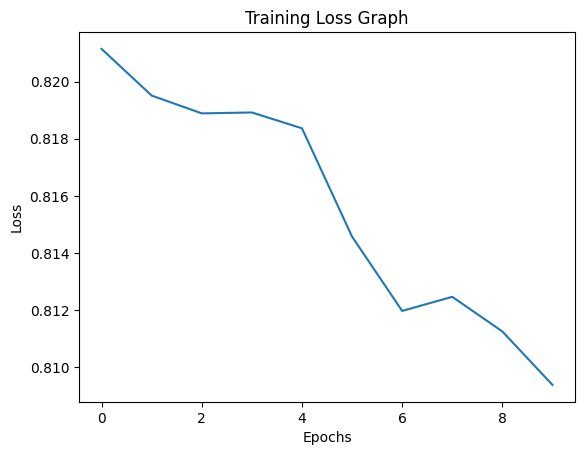

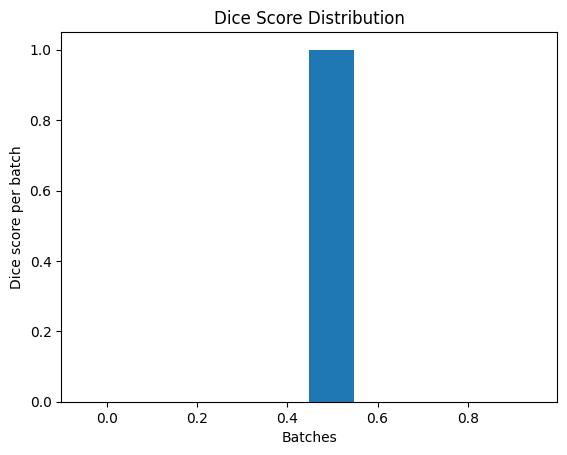

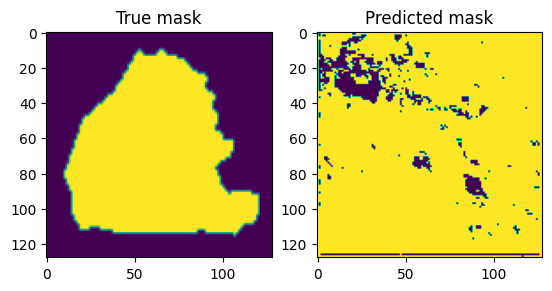

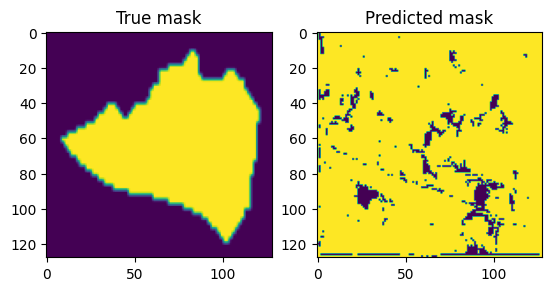

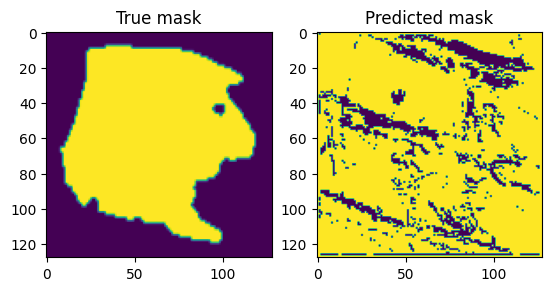

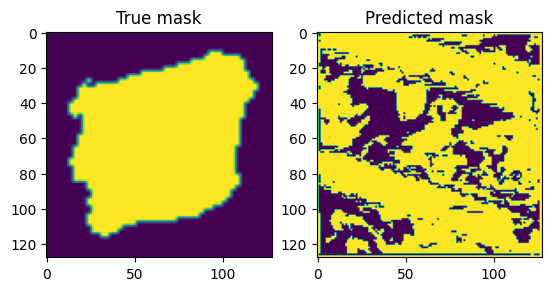

In [15]:
# TODO -  add title for image resuls
# update the gif generation code on github
exp_folder = 'experiments/'

if not os.path.exists(exp_folder):
    os.mkdir(exp_folder)

if not os.path.exists(exp_folder+"thecounter.data"):
    counter = open(exp_folder+"thecounter.data","w")
    counter.write('10000')
    counter.close()

with open(exp_folder+"thecounter.data","r") as counter:
    count = int(counter.read())
    counter.close()

count += 1

if not os.path.exists(exp_folder+f"{count}"):
    os.makedirs(exp_folder+f"{count}")

new_folder = exp_folder + f"{count}/"

filename = new_folder+'hyperparameters.txt'

file = open(filename,'a+')
file.write(f"""Hyperparameters

LEARNING_RATE = {LEARNING_RATE}
WEIGHT_DECAY = {WEIGHT_DECAY}
UNFREEZE_WEIGHTS = {UNFREEZE_WEIGHTS}
EPOCHS = {EPOCHS}
EPOCH_FREEZE = {EPOCH_FREEZE}
PROB_THRESHOLD = {PROB_THRESHOLD}
MAKE_CSV = {MAKE_CSV}
TEST_SIZE = {TEST_SIZE}
TRANSFORMS = {TRANSFORMS}
LOSS = {LOSS}""")
file.close()

plt.figure(0)
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Training Loss Graph")
plt.savefig(new_folder+'train_losses.png')


plt.figure(1)
plt.hist(dices)
plt.xlabel('Batches')
plt.ylabel('Dice score per batch')
plt.title("Dice Score Distribution")
plt.savefig(new_folder+'dice_hist.png')

torch.save(torch_model, new_folder+'model')

imgs, segs = next(iter(test_dataloader)) #
outputs = torch_model.forward(imgs.to(device))
outputs = torch.softmax(outputs, dim=1)

if not os.path.exists(new_folder+'results/'):
    os.mkdir(new_folder+'results/')


plt.figure(2)
for IMG in range(len(imgs)):
    plt.subplot(1,2,1)
    plt.title("True mask")
    plt.imshow(segs[IMG,:,:,:].squeeze(0))
    plt.subplot(1,2,2)
    plt.imshow(outputs[IMG].detach().cpu().numpy()[1]>=PROB_THRESHOLD)
#     print(f'{str(IMG+10000)}.png')
    plt.title("Predicted mask")
    plt.savefig(new_folder+f'results/{str(IMG+1000)}.png')
    plt.show()


counter = open(exp_folder+"thecounter.data","w")
counter.write(str(count))
counter.close()


10000.png


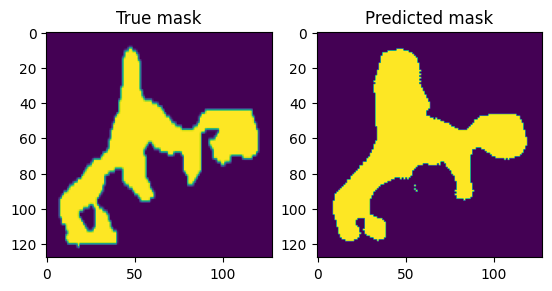

10001.png


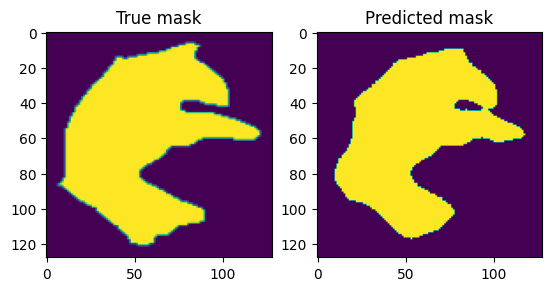

10002.png


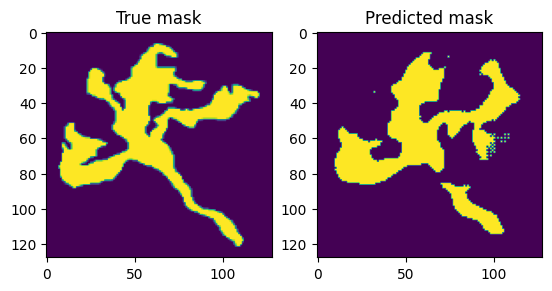

10003.png


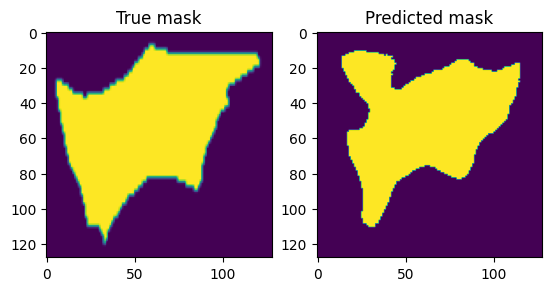

10004.png


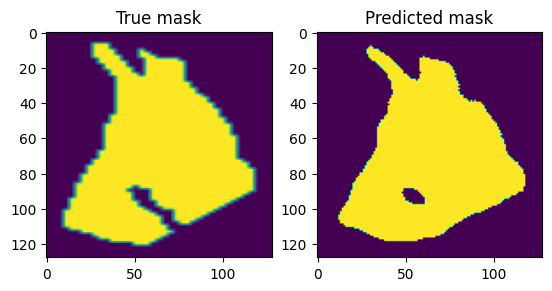

10005.png


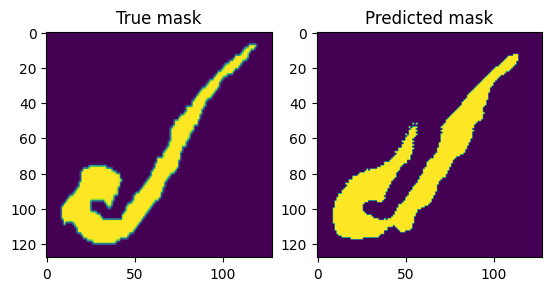

10006.png


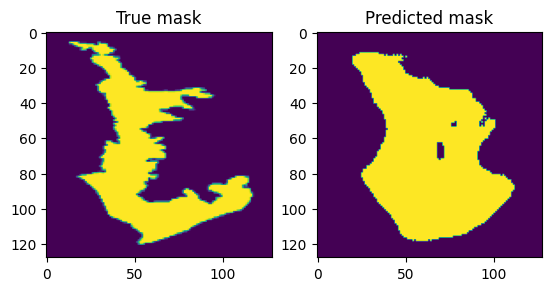

10007.png


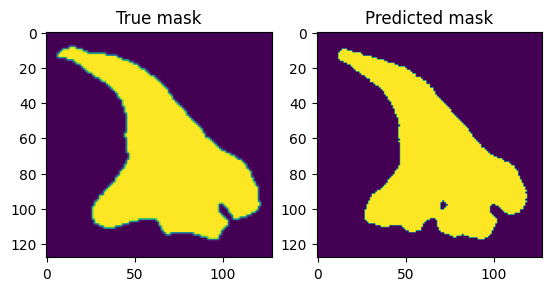

10008.png


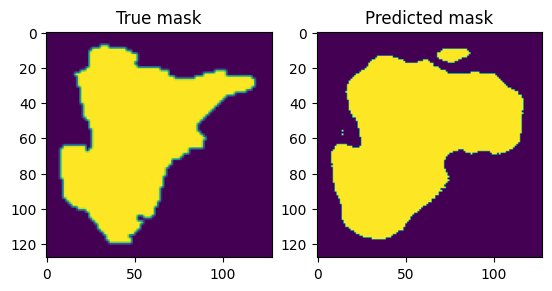

10009.png


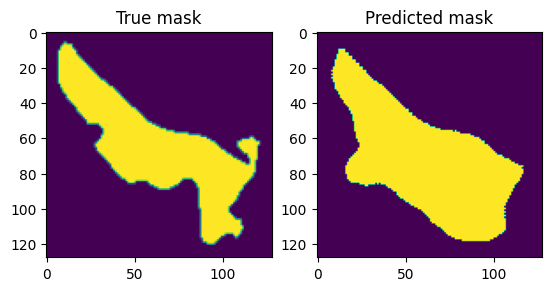

10010.png


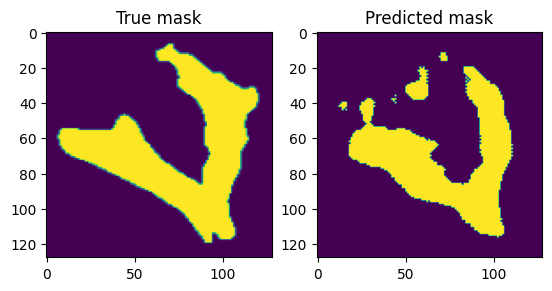

10011.png


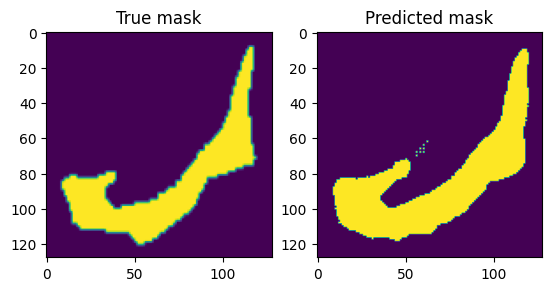

10012.png


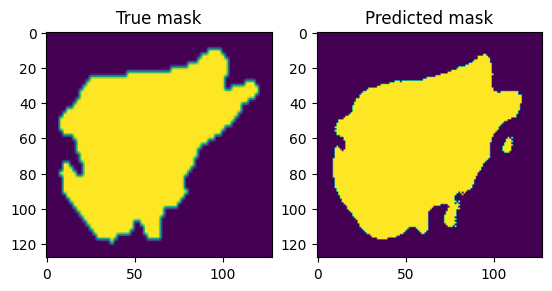

10013.png


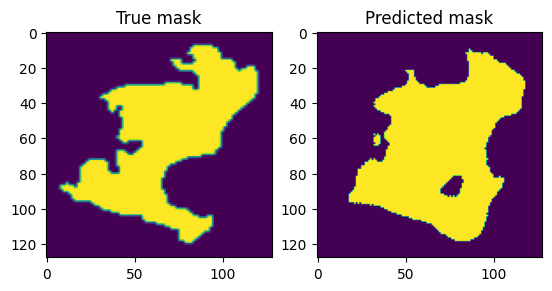

10014.png


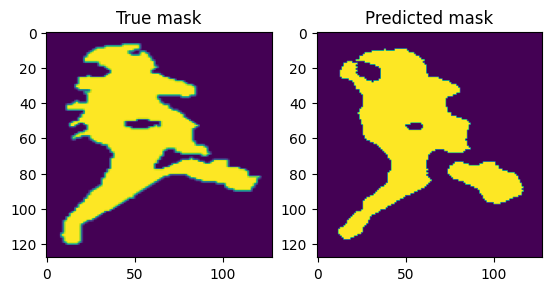

10015.png


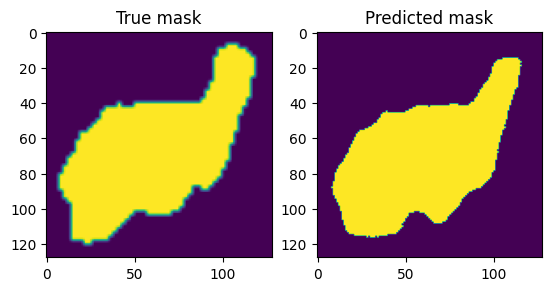